In [2]:
# activate ASTRAL/era5, using packages
cd(joinpath(homedir(), "Projects/ASTRAL/era5/src")) # working directory is src
using Pkg; Pkg.activate("..")    # Project is era5

using NCDatasets
using PyPlot
using Dates
# using FiniteDifferences
# using Plots

  Activating project at `~/Projects/ASTRAL/era5`
[ Info: Precompiling NCDatasets [85f8d34a-cbdd-5861-8df4-14fed0d494ab]


In [3]:
module Thermo
# thermodynamics of moist air functions

export theta_equiv

# constants
const Cp = 1005.7  # from my Davies-Jones function, was 1005.
const Cpv = 1870.0 # J/kg/K
const Cw  = 4190.0
const L0 = 2.501e6 # J/kg

const C = 273.15 # K

const Rd = 287.04
const Rv = 461.5
const RdoRv=Rd/Rv

"latent heat of water vapor"
LvK(TempK) = 2.501e6 + (Cpv-Cw) * (TempK-273.0)

"""
es(T,p) = is saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [Pa] (note the reversed input order), es [Pa]
Calling with optional keywords changes the units and
ignores the positional arguments.
es(T,p; TK=tk[Kelvin], P=pr[hPa])
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function es(T, p=1e5)
    # P in hPa
    P=p*1e-2
    esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # es in Pa
end

"es in hPa, same as keyword P[hPa]"
function es(T; P)
    # P in hPa
    esat =       6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # es in hPa, same as P
end

# # supply TK [Kelvin] by keyword, ignores positional T!!
# function es(T,p=1e5; TK=T+C, P=p*1e-2)
#     # P in hPa
#     T = TK - C
#     esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # convert es to Pa
# end

"""
qs(p,T) is saturation specific humidity based on Wexler's formula for es
with enhancement factor (see es.m).
p [Pa], T [degrees C], qs [kg/kg]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function qs(p,T)
    esat = es(T,p) # T[C], p[Pa] method
    qsat = RdoRv*esat / (p + (RdoRv-1)*esat)
end

"dqsdT(p,T[C]) derivative of qs with respect to T at p,T by autodiff of Bolton's qs"
dqsdT(p,T) = ForwardDiff.derivative(t -> qs(p,t), T)

# wet bulb temperature methods
# for approximating the evap process

"General single Newton iteration to update x toward f(x) = fhat for a univariate function f"
updatex(f, x, fhat) = x + (fhat-f(x)) / ForwardDiff.derivative(f, x)

"""
Twet_autodiff(T[K], q[kg/kg], p[Pa]; niter=2) wet bulb temperature using Newton's method
for target specific humidity q[kg/kg]. Uses automatic differntiation.
"""
function Twet_autodiff(T, q, p; niter=2)
    f(t) = (t - T) + LvK((T+t)/2)/Cp * (qs(p,t-C) - q)
    t=T
    for i in 1:niter
        t = updatex(f, t, 0)
    end
    t
end
# 2 iterations converges to ~0.001 K

# call as...
# q = rh*qs(pa, Ta)
# Twet_autodiff(Ta, rh*qs(pa, Ta-C), pa)


# thermo functions

"Exner(p/p0) = T/θ = (p/p0)^(Rd/Cp)"
Exner(p) = p^0.287
Exner(p, qv) = p ^ ((Rd/Cp) * (1 - 0.28*qv))

"potential temperature [K] = theta(T[K], p[hPa])"
theta(T, p) = T / Exner(p/1000.0)
theta(T, p, qv) = T / Exner(p/1000.0, qv)

"vapor pressure ev(p,qv); ev has units of p"
ev(p, qv) = p*qv / (RdoRv + qv)

"T[K] LCL from Bolton, Temp[K], ev[hPa]"
Tlcl(Temp, ev) = 2840/(3.5*log(Temp) - log(ev) - 4.805) + 55;
Tlcl(Temp, p, qv) = Tlcl(Temp, ev(p,qv))

"equivalent potential temperature"
function theta_equiv(T::Real, p::Real, qv::Real)
    Tl = Tlcl(T, p, qv)
    thetae = theta(T,p,qv) * exp((3376.0/Tl - 2.54) * qv * (1 + 0.81*qv))
end

# qs(1e2*1000, 290.0-C)
"equivalent saturated potential temperature theta_equiv_sat(T[K], p[hPa])"
theta_equiv_sat(T, p) = theta_equiv( T, p, qs(1e2*p, T-C) )

end # module Thermo

using .Thermo

In [4]:
# read one file
# lon = 69
lat = 12
ncfile = filter(x->contains(x,"$(lat)n_2023") && endswith(x,".nc"), readdir())[1]
ds = NCDataset(ncfile)

iit = findfirst(ds[:time].>=DateTime(2023,6,4)) # 2023 June 4

35

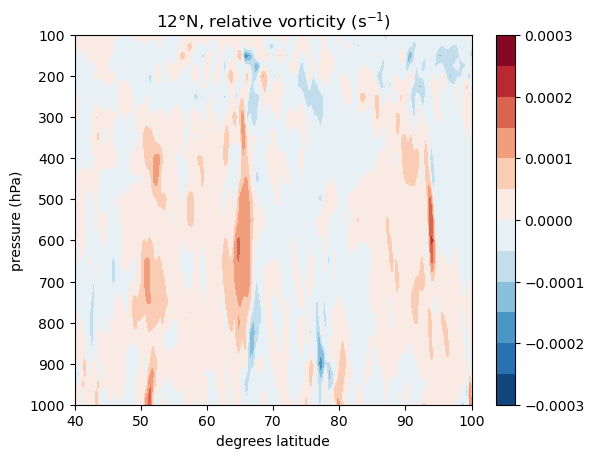

PyObject Text(0.5, 1.0, '12°N, relative vorticity (s$^{-1}$)')

In [5]:
# plot relative vorticity

pd = permutedims
clf()
contourf(ds[:longitude][:], ds[:level][:],
    pd(ds[:vo][:,1,:,iit]), 
    cmap=ColorMap("RdBu_r"), 
    # vmin=-3e-4, vmax=3e-4, 
    levels=1e-4*(-3:0.5:3) )
colorbar()
ylim([1000,100])
xlabel("degrees latitude")
ylabel("pressure (hPa)")
title("$(lat)°N, relative vorticity (s"*L"^{-1}"*")")
# gcf()


In [6]:
# finite differences for arrays

const æ = 6.37e6 # radius of earth

"deprecated meridional derivative. ∂y(u) has same size as u"
function ∂y_old(u, y=ds[:latitude][:])
    # u = ds[:u][1,:,:,:] # eliminate singleton dim
    du = diff(u, dims=1)
    dy = æ * pi/180 * ([0; diff(y,dims=1)] .+ [diff(y,dims=1); 0])
    uy = zeros(size(u))
    uy[1:end-1,:,:] .= du
    uy[2:end,:,:] .+= du
    uy ./ dy
end

"""
Evaluate the vectorized operation f() along dimension dim of array x
looping over all other dimensions.
"""
function loopopdim(f, dim::Integer, x::AbstractArray)
    s = similar(x)
    Rpre = CartesianIndices(size(x)[1:dim-1])
    Rpost = CartesianIndices(size(x)[dim+1:end])
    _loopopdim!(f, s, x, Rpre, size(x, dim), Rpost)
end

function _loopopdim!(f, s, x, Rpre, n, Rpost)
    for Ipost in Rpost
        for Ipre in Rpre
            s[Ipre, :, Ipost] .= f( x[Ipre, :, Ipost] )
        end
    end
    s
end

"1st-order centered finite difference, padding end points with uncentered differences."
fdpad(x::Vector) = [ x[2]-x[1]; x[3:end].-x[1:end-2]; x[end]-x[end-1] ]

function ∂y(u=ds[:u][1,:,:,:], y=ds[:latitude][:])
    du =              loopopdim(fdpad, 1, u) 
    dy = æ * pi/180 * loopopdim(fdpad, 1, y)
    du ./ dy
end

# extend loopopdim to use like mapslices
"""
Evaluate the vectorized operation f(x,y) along dimension dim of array x
that matches vector y; looping over all other dimensions.
"""
function loopopdim(f, dim::Integer, x::AbstractArray, y::Vector)
    s = similar(x)
    Rpre = CartesianIndices(size(x)[1:dim-1])
    Rpost = CartesianIndices(size(x)[dim+1:end])
    _loopopdim!(f, s, x, Rpre, size(x, dim), Rpost, y)
end

function _loopopdim!(f, s, x, Rpre, n, Rpost, y)
    for Ipost in Rpost
        for Ipre in Rpre
            s[Ipre, :, Ipost] .= f( x[Ipre, :, Ipost], y )
        end
    end
    s
end

"∂logT/∂logp"
function ∂lnp(t=log.(ds[:t][1,:,:,:]), p=ds[:level][:])
    dlnT = loopopdim(fdpad, 2, t)
    dlnp = loopopdim(fdpad, 1, log.(p))
    # dlnTdlnp = loopopdim(./, 2, dlnT, dlnp ) # broadcast /dlnp along 2d dim of dlnT
    # mapslices of a broadcasting function !! yay !!
    dTdlnp = mapslices(x->x./dlnp, dlnT, dims=2)
end

∂lnp

In [7]:
# compute the finite differences
# dlnTdy = ∂y( log.(ds[:t][1,:,:,:]) )
# dudy = ∂y( ds[:u][1,:,:,:] )
# dvdx = ds[:vo][1,:,:,:] .+ dudy

# # compare old and new methods
# maximum(abs, ∂y_old( ds[:u][1,:,:,:] ) .- dudy ) # tiny, 10^-19

dlnTdlnp = ∂lnp( log.(ds[:t][:,1,:,:]) )

241×37×61 Array{Float64, 3}:
[:, :, 1] =
 -0.0297088   -0.0429096   -0.0815246  …  0.179899   0.192314   0.190074
 -0.0297234   -0.0424093   -0.0822884     0.208906   0.187378   0.193613
 -0.0292536   -0.042195    -0.0832627     0.248272   0.191301   0.183797
 -0.0283545   -0.0422145   -0.0842838     0.196855   0.188886   0.189875
 -0.0271337   -0.0423681   -0.0851994     0.167866   0.182981   0.191677
 -0.0257073   -0.0425883   -0.0859576  …  0.173093   0.18536    0.188447
 -0.0242431   -0.0427863   -0.0864909     0.172193   0.21144    0.19448
 -0.022897    -0.0429129   -0.086772      0.180542   0.217159   0.191848
 -0.0217518   -0.0429128   -0.0867881     0.201133   0.19863    0.186453
 -0.0208484   -0.0427439   -0.086566      0.194457   0.204696   0.188941
 -0.0202072   -0.0423579   -0.0861316  …  0.191971   0.187369   0.194598
 -0.019807    -0.0417612   -0.0855686     0.204446   0.19058    0.188833
 -0.0197312   -0.0409257   -0.0848801     0.180836   0.212005   0.188042
  ⋮        

In [8]:
# compute characteristic frequencies for dry symmetric instabilities
# in the meridional-vertical plane (69E)
# Bennetts and Hoskins 1979
# Assume ERA5 is geostrophic zonal base state flow field.

const grav = 9.8 
const Rd = 287.0
const Cp = 1005.0
RdoCp = Rd/Cp
const Ω = 7.2921159e-5 # s-1

# buoyancy frequency squared
N² = @. grav^2 / (Rd*ds[:t][:,1,:,:]) * (RdoCp - dlnTdlnp) # s-2

# inertial frequency squared
fCoriolis(y) = 2*Ω*sind(y)
# F2fcn(f, dudy) = f*(f-dudy)
# F² = mapslices(dudy-> F2fcn.(fCoriolis.(ds[:latitude][:]), dudy), dudy, dims=1)
# thermal wind (shear)
# S² = -grav * dlnTdy # = f du/dz
# # Ertel potential vorticity
# q = @. F²*N² - S²*S²
#
# σ_min² = @. ( N² + F² - sqrt((N² + F²)^2 - 4*q) )/2 # s^-2, +imaginary part indicates unstable growth
# σ_unst = @. sqrt( Complex(σ_min²) ) # frequency of least stable symmetric mode

fCoriolis (generic function with 1 method)

In [9]:
"reuse figure handle; reinitiate and resize the figure"
function recaplot(fig::Symbol; figsize=(4,6))
    if isdefined(Main, :fig) && isa(:($fig), Figure)
        fig = :($fig)
        figvo = figure(fig, figsize=figsize)
    else
        figvo = figure(figsize=figsize)
    end
    return figvo
end
# don't like this metajunk

recaplot

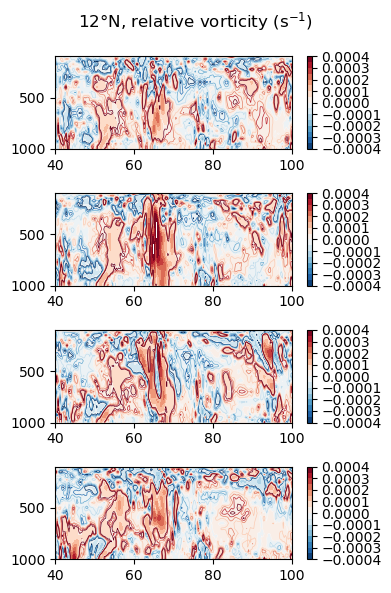

In [10]:
# plot vorticity

figvo = recaplot(:figvo, figsize=(4,6))
# figvo, axs = subplots(4,1)

iplt = 0
for dtx in DateTime(2023,6,5):Day(1):DateTime(2023,6,8)
    it = findfirst(dt -> dt>=dtx, ds[:time][:] ) # 2023 June 6
    iplt += 1

    subplot(4,1,iplt)
    contourf(ds[:longitude][:], ds[:level][:],
        pd(ds[:vo][:,1,:,it]), 
        cmap=ColorMap("RdBu_r"), 
        # vmin=-3e-4, vmax=3e-4, 
        levels=1e-4*(-4:0.5:4) )
    colorbar()
    contour(ds[:longitude][:], ds[:level][:],
        pd(ds[:vo][:,1,:,it]), 
        cmap=ColorMap("RdBu_r"), 
        # vmin=-3e-4, vmax=3e-4, 
        levels=1e-5*(-4:4),
        linewidths=0.5 )
    ylim([1000,100])
    # xlabel("degrees latitude")
    # ylabel("pressure (hPa)")
end
suptitle("$(lat)°N, relative vorticity (s"*L"^{-1}"*")")
tight_layout()
# gcf()

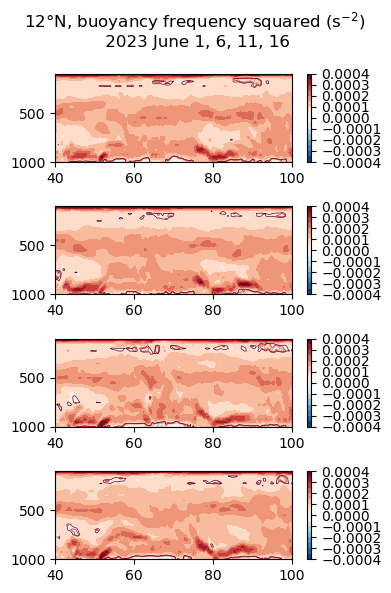

In [11]:
# plot N²

fign2 = recaplot(:fign2; figsize=(4,6))

iplt = 0
for dtx in DateTime(2023,6,3):Day(2):DateTime(2023,6,9)
    it = findfirst(dt -> dt>=dtx, ds[:time][:] ) # 2023 June 6
    iplt += 1

    subplot(4,1,iplt)
    contourf(ds[:longitude][:], ds[:level][:],
        pd(N²[:,:,it]), 
        cmap=ColorMap("RdBu_r"), 
        # vmin=-3e-4, vmax=3e-4, 
        levels=1e-4*(-4:0.5:4) )
    colorbar()
    contour(ds[:longitude][:], ds[:level][:],
        pd(N²[:,:,it]), 
        cmap=ColorMap("RdBu_r"), 
        # vmin=-3e-4, vmax=3e-4, 
        levels=1e-5*(-4:4),
        linewidths=0.5 )
    ylim([1000,100])
    # xlabel("degrees latitude")
    # ylabel("pressure (hPa)")
end
suptitle("$(lat)°N, buoyancy frequency squared (s"*L"^{-2}"*")\n 2023 June 1, 6, 11, 16")
tight_layout()

In [12]:
# equivalent potential temperatures
equiv_pot_temp(p, t, q) = Thermo.theta_equiv.(t,pd(p),max.(0.0,q))
sat_equiv_pot_temp(p,t) =  Thermo.theta_equiv_sat.(t,pd(p))

θe = equiv_pot_temp(ds[:level][:], ds[:t][:,1,:,:], ds[:q][1,:,:,:])
θes = sat_equiv_pot_temp(ds[:level][:], ds[:t][:,1,:,:])
dlnθedlnp = ∂lnp( log.(θe) ) # banded
dlnθesdlnp = ∂lnp( log.(θes) )
size(θe)

(241, 37, 61)

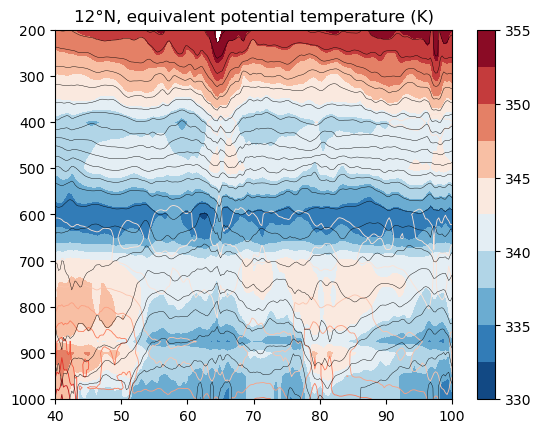

(1000.0, 200.0)

In [14]:
# plot equivalent potential temperature and potential temperature

dtx = DateTime(2023,6,6)
it = findfirst(dt -> dt>=dtx, ds[:time][:] )
 
clf()
contourf(ds[:longitude][:], ds[:level][:], pd(θe[:,:,it]),
    cmap=ColorMap("RdBu_r"), levels=330:2.5:355)
colorbar()
contour(ds[:longitude][:], ds[:level][:], pd(θes[:,:,it]-θe[:,:,it]),
    cmap=ColorMap("Reds"), linewidths=0.6, levels=0:10:90)
contour(ds[:longitude][:], ds[:level][:], 
    pd(Thermo.theta.(ds[:t][:,1,:,it],pd(ds[:level][:]))),
    colors="k", linewidths=0.3, levels=280:2.5:420)
ylim([1000, 100])
title("$(lat)°N, equivalent potential temperature (K)")
ylim([1000,200])
# gcf()

Equivalent potential temperature vertical structure is more or less piecewise linear and continuous.

In [15]:
# equivalent buoyancy frequency squared (accounts for saturated latent heating) 
Nequiv² = @. -grav^2 / (Rd*ds[:t][:,1,:,:]) * dlnθedlnp # s-2

241×37×61 Array{Float64, 3}:
[:, :, 1] =
 0.000395894  0.000421063  0.000483238  …  0.000106505   0.000108574
 0.000395828  0.000420336  0.000483874     0.000112247   0.000104516
 0.000395147  0.000419828  0.000484931     0.00010765    0.000115792
 0.000393948  0.000419516  0.000486197     0.000110501   0.000108833
 0.000392387  0.000419328  0.000487449     0.000117219   0.000106644
 0.000390616  0.000419216  0.000488589  …  0.000114472   0.000110375
 0.000388841  0.000419113  0.000489477     8.42261e-5    0.000103312
 0.000387245  0.000418985  0.000490034     7.76611e-5    0.000106403
 0.000385925  0.000418781  0.000490206     9.89908e-5    0.000112523
 0.000384925  0.00041845   0.000489994     9.1986e-5     0.000109657
 0.000384265  0.000417931  0.0004894    …  0.000112106   0.000103239
 0.000383916  0.000417221  0.000488534     0.00010837    0.000109864
 0.000383974  0.000416301  0.000487376     8.35868e-5    0.000110749
 ⋮                                      ⋱  ⋮            
 0.00

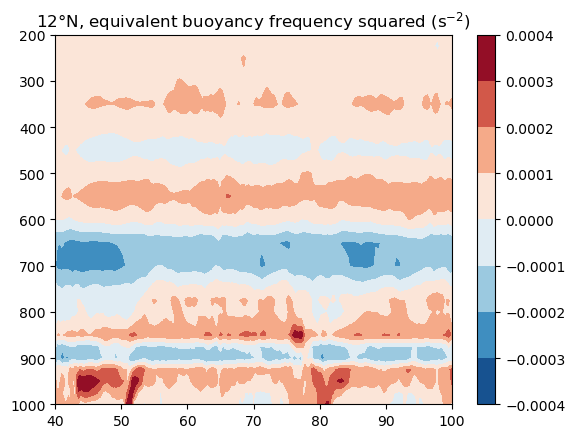

(1000.0, 200.0)

In [16]:
# plot equivalent buoyancy frequency squared

dtx = DateTime(2023,6,6)
it = findfirst(dt -> dt>=dtx, ds[:time][:] )
 
clf()
contourf(ds[:longitude][:], ds[:level][:], pd(Nequiv²[:,:,it]),
    cmap=ColorMap("RdBu_r"), levels=-4e-4:1e-4:4e-4)
colorbar()
# contour(ds[:longitude][:], ds[:level][:], pd(θe[:,:,it]),
#     colors="k", levels=300:2.5:400, linewidth=0.2)
#     #cmap=ColorMap("Reds"), linewidths=0.6)
# contour(ds[:longitude][:], ds[:level][:], 
#     pd(Thermo.theta.(ds[:t][:,1,:,it],pd(ds[:level][:]))),
#     colors="k", linewidths=0.3, levels=280:2.5:420)
ylim([1000, 100])
title("$(lat)°N, equivalent buoyancy frequency squared (s\$^{-2}\$)")
ylim([1000,200])

# what an unrealistic looking complex banded structure!

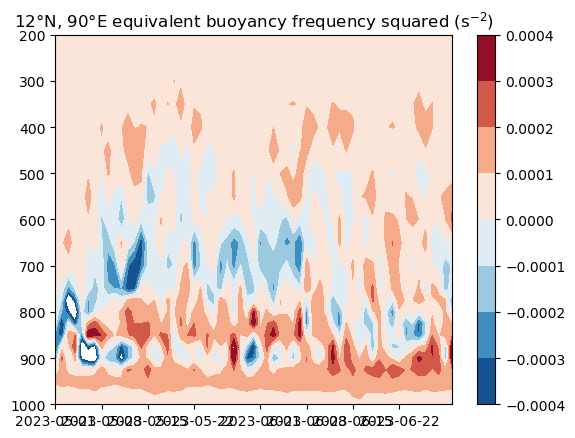

(1000.0, 200.0)

In [52]:
# plot 90E N2_e all times
ilon = findfirst( ds[:longitude][:] .>= 90 )


nmean = sum(Nequiv², dims=1) ./ sum(isfinite.(Nequiv²), dims=1)

clf()
contourf(ds[:time][:], ds[:level][:], nmean[1,:,:],
    cmap=ColorMap("RdBu_r"), levels=-4e-4:1e-4:4e-4)
colorbar()
title("$(lat)°N, 90°E equivalent buoyancy frequency squared (s\$^{-2}\$)")
ylim([1000,200])

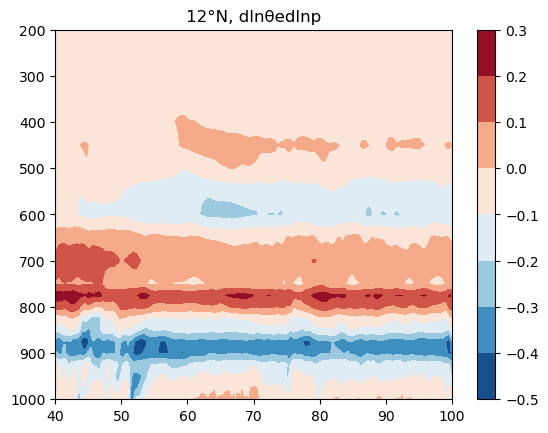

(1000.0, 200.0)

In [53]:
# plot dlnθedlnp

clf()
contourf(ds[:longitude][:], ds[:level][:], pd(dlnθedlnp[:,:,it]),
    cmap=ColorMap("RdBu_r"))
colorbar()
ylim([1000, 100])
title("$(lat)°N, dlnθedlnp")
ylim([1000,200])

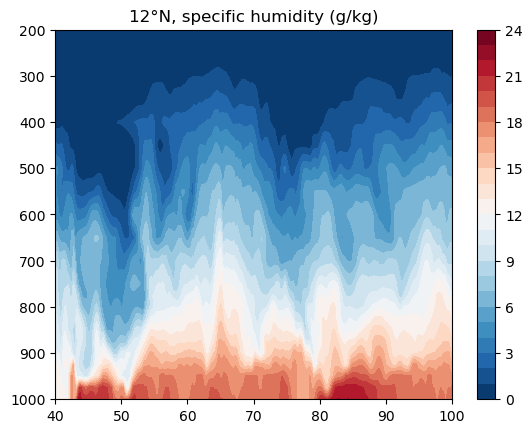

(1000.0, 200.0)

In [26]:
# plot humidity

dtx = DateTime(2023,6,6)
it = findfirst(dt -> dt>=dtx, ds[:time][:] )
 
clf()
contourf(ds[:longitude][:], ds[:level][:], 1e3*pd(ds[:q][:,1,:,it]),
    cmap=ColorMap("RdBu_r"), levels=0:24)
# contourf(ds[:longitude][:], ds[:level][:], log.(pd(ds[:q][:,1,:,it])),
#     cmap=ColorMap("RdBu_r"), levels=-10:.5:-3)
colorbar()
ylim([1000, 100])
title("$(lat)°N, specific humidity (g/kg)")
ylim([1000,200])

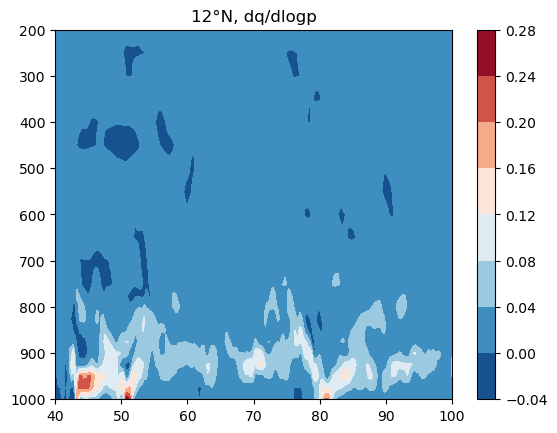

(1000.0, 200.0)

In [40]:
clf()
contourf(ds[:longitude][:], ds[:level][:], pd(∂lnp((ds[:q][:,1,:,it]))),
    cmap=ColorMap("RdBu_r") )
colorbar()
ylim([1000, 100])
title("$(lat)°N, dq/dlogp")
ylim([1000,200])

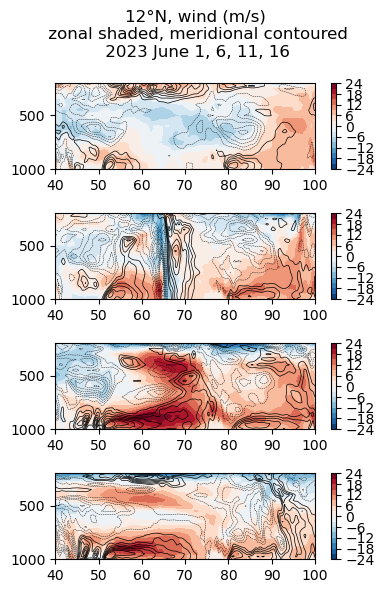

In [65]:
# plot wind 

clf()
figwnd = recaplot(:figwnd, figsize=(4,6))

iplt=0
for dtx in DateTime(2023,6,1):Day(5):DateTime(2023,6,16)
    it = findfirst(dt -> dt>=dtx, ds[:time][:] )
    iplt += 1
    subplot(4,1,iplt)

    contourf(ds[:longitude][:], ds[:level][:], pd(ds[:u][:,1,:,it]),
        cmap=ColorMap("RdBu_r"), levels=-24:3:24)
    colorbar()
    contour(ds[:longitude][:], ds[:level][:], 
        pd(ds[:v][:,1,:,it]),
        colors="k", linewidths=0.5, levels=2:2:16)
    contour(ds[:longitude][:], ds[:level][:], 
        pd(ds[:v][:,1,:,it]),
        colors="k", linewidths=0.3, levels=-16:2:-2, linestyles="--")
    ylim([1000,200])
end
suptitle("$(lat)°N, wind (m/s)\n zonal shaded, meridional contoured\n 2023 June 1, 6, 11, 16")
tight_layout()
# gcf()

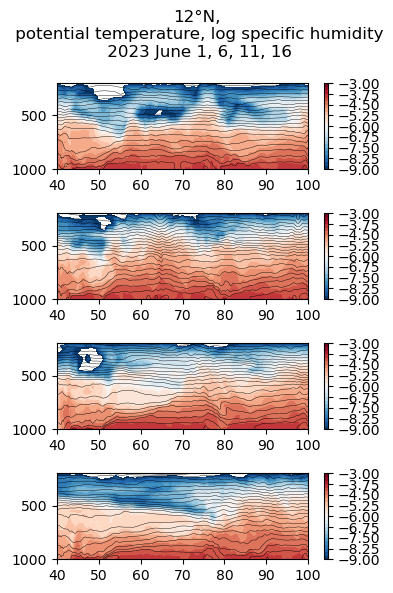

In [74]:
# plot humidity

clf()
fighum = recaplot(:fighum, figsize=(4,6))

iplt=0
for dtx in DateTime(2023,6,1):Day(5):DateTime(2023,6,16)
    it = findfirst(dt -> dt>=dtx, ds[:time][:] )
    iplt += 1
    subplot(4,1,iplt)

    contourf(ds[:longitude][:], ds[:level][:], pd(log.(ds[:q][:,1,:,it])),
        cmap=ColorMap("RdBu_r"), levels=-9:0.25:-3)
    colorbar()
    contour(ds[:longitude][:], ds[:level][:], 
        pd(Thermo.theta.(ds[:t][:,1,:,it],pd(ds[:level][:]))),
        colors="k", linewidths=0.3, levels=280:2.5:420)
    ylim([1000,200])
end
suptitle("$(lat)°N,\n potential temperature, log specific humidity\n 2023 June 1, 6, 11, 16")
tight_layout()
# gcf()